# ISTM 6216 Final Project

### Group 6
Qi Ding  
Siye An  
Hanwei Zhao  

# Part One: Data Selection

The dataset is provided by the Authorities Budget Office. Data is reported by each State Authority beginning with the fiscal year ending in 2011. The dataset is acquired from its publisher: State of New York. It contains information on various salary information of 868K employees in 46 state authorities: base annualized salary, actual salary paid, overtime pay, performance bonus, extra pay, other compensation, and total compensation. 

We select this dataset to study the salary distribution across years, authorities, groups and departments in public sector. Moreover, it offers useful insights  with respect to the proportion of each salary component in the total compensation. 

# Part Two:  Data Exploration and Wrangling

### 2.1 Overview of the original dataset

- From the output of 'wc -l', we know there are over 868 thousands of records in the salary dataset. This increased the difficulty of wrangling the data because Trifacta can upload maximum 100 MB file every time.  
- From the output of 'csvstat -n', there are originally 20 attributes in the dataset:
  - 1: Authority Name
  - 2: Fiscal Year End Date
  - 3: Has Employees
  - 4: Last Name
  - 5: Middle Initial
  - 6: First Name
  - 7: Title
  - 8: Group
  - 9: Department
  - 10: Pay Type
  - 11: Exempt Indicator
  - 12: Base Annualized Salary
  - 13: Actual Salary Paid
  - 14: Overtime Paid
  - 15: Performance Bonus
  - 16: Extra Pay
  - 17: Other Compensation
  - 18: Total Compensation
  - 19: Paid By Another Entity
  - 20: Paid by State or Local Government

In [7]:
!wget https://datamanagement-groupwork3.s3.amazonaws.com/Salary_Information_for_State_Authorities.csv

--2019-11-22 23:38:25--  https://datamanagement-groupwork3.s3.amazonaws.com/Salary_Information_for_State_Authorities.csv
Resolving datamanagement-groupwork3.s3.amazonaws.com (datamanagement-groupwork3.s3.amazonaws.com)... 52.216.112.156
Connecting to datamanagement-groupwork3.s3.amazonaws.com (datamanagement-groupwork3.s3.amazonaws.com)|52.216.112.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160255379 (153M) [text/csv]
Saving to: 'Salary_Information_for_State_Authorities.csv'

Salary_Information_ 100%[===================>] 152.83M  42.3MB/s    in 3.6s    

2019-11-22 23:38:28 (42.2 MB/s) - 'Salary_Information_for_State_Authorities.csv' saved [160255379/160255379]



In [9]:
!mv Salary_Information_for_State_Authorities.csv salary.csv

mv: cannot stat 'Salary_Information_for_State_Authorities.csv': No such file or directory


In [16]:
!wc -l salary.csv

868379 salary.csv


In [17]:
!csvstat -n salary.csv

  1: Authority Name
  2: Fiscal Year End Date
  3: Has Employees
  4: Last Name
  5: Middle Initial
  6: First Name
  7: Title
  8: Group
  9: Department
 10: Pay Type
 11: Exempt Indicator
 12: Base Annualized Salary
 13: Actual Salary Paid
 14: Overtime Paid
 15: Performance Bonus
 16: Extra Pay
 17: Other Compensation
 18: Total Compensation
 19: Paid By Another Entity
 20: Paid by State or Local Government


### 2.2 Find problems in the original dataset by Csvkit Tools and XSV Tools

Since Trifacta can only observe limited amount of data, we use unix shell commands combined with csvstat to explore the original data at the beginning. We find there are mainly three problems in our dataset:  
- The column "Has Employees" is totally blank. According to the data dictionary in the official website, it indicates that all the authorites reported having staff.  
- The column "Paid By Another Entity" is all assigned with "False" value.
- The column "Paid by State or Local Government" is empty. According to data dictionary in the official website, blank(missing values) indicates that the employee is not paid by state or local government.

In [15]:
!head -n 50000 salary.csv| csvstat

  1. "Authority Name"

	Type of data:          Text
	Contains null values:  False
	Unique values:         6
	Longest value:         62 characters
	Most common values:    Metropolitan Transportation Authority (45672x)
	                       Erie County Medical Center Corporation (4257x)
	                       Long Island Power Authority (62x)
	                       Agriculture and New York State Horse Breeding Development Fund (3x)
	                       Erie County Fiscal Stability Authority (3x)

  2. "Fiscal Year End Date"

	Type of data:          Date
	Contains null values:  False
	Unique values:         1
	Smallest value:        2018-12-31
	Largest value:         2018-12-31
	Most common values:    2018-12-31 (49999x)

  3. "Has Employees"

	Type of data:          Boolean
	Contains null values:  True (excluded from calculations)
	Unique values:         1
	Most common values:    None (49999x)

  4. "Last Name"

	Type of data:          Text
	Contains null values:  False
	Unique va

In [12]:
!xsv stats salary.csv | xsv table

field                              type     sum                 min                                                             max                                         min_length  max_length  mean                stddev
Authority Name                     Unicode                      Agriculture and New York State Horse Breeding Development Fund  Westchester County Health Care Corporation  22          85                              
Fiscal Year End Date               Unicode                      03/31/2011                                                      12/31/2018                                  10          10                              
Has Employees                      Unicode                      No                                                              No                                          0           2                               
Last Name                          Unicode                      AAMIR                                                         

### 2.3 Data Wrangling on Trifacta

The findings on Trifacta platform are a little bit different from those manifested by csvkit. We use stratified sample based on fiscal year and the sample contains 36348 rows. The reason behind the difference results from the fact that 'csvstat' only studies the first 50000 rows which are all from 2018 fiscal year. Using stratified sampling, we can have an unbiased understanding of the characteristics of the dataset.

- For the column "Has Employees", firstly, we delete rows where the value of this attribute is 'N' which indicates that there is no employees in this authority. Secondly, we choose to delete this column, since it doesn't offer futher useful information.
- For the column "Paid By Another Entity", we choose to retain it, since there are approximately 1% employees who are paid by another entity.
- For the column "Paid by State or Local Government", we choose to transform the missing values into "N", since there are 0.01% employeed who are paid by state or local government. 
- For the column "Department", we replace missing values with "Not Entered" to show that the reporters don't report this column. 
- For the all columns, we find there are redundant quotes in some attributes, such as "Last Name", "Middle Initial" and "First Name". We decide to remove the extra quotes. 

We split the 160 MB orginal file into two files, and create the same recipe for both of them on Trifacta:

```

exactly col: {Has Employees} exactly: 'No' action: Delete
drop col: {Has Employees} action: Drop
replacemissing col: {Paid by State or Local Government} with: custom text: 'N'
replacemissing col: Department with: custom text: 'Not Entered'
replacepatterns col: {Last Name}, {Middle Initial}, {First Name}, {Authority Name}, Title, Group, Department, {Pay Type}, {Exempt Indicator} with: ' ' on: '\"'
replacepatterns col: {Last Name}, {Middle Initial}, {First Name}, {Authority Name}, Title, Group, Department, {Pay Type}, {Exempt Indicator} with: ' ' on: '\"'

```

### 2.4 Re-exploring the data by Csvkit Tools and XSV Tools

- We use XSV tool "xsv cat rows" to stack the two large files because csvstack are less efficient in terms of dealing with large dataset.
- We use csvstat to study the wrangled dataset. From the output, we can find that "Has Employees" is deleted and "paid by state or governement" is transformed by adding 'N' for missing values. 

In [31]:
# get data file salary 1
!wget https://datamanagement-groupwork3.s3.amazonaws.com/salary_1.csv

--2019-11-26 18:20:03--  https://datamanagement-groupwork3.s3.amazonaws.com/salary_11.csv
Resolving datamanagement-groupwork3.s3.amazonaws.com (datamanagement-groupwork3.s3.amazonaws.com)... 52.217.11.84
Connecting to datamanagement-groupwork3.s3.amazonaws.com (datamanagement-groupwork3.s3.amazonaws.com)|52.217.11.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100566674 (96M) [text/csv]
Saving to: 'salary_11.csv'

salary_11.csv       100%[===================>]  95.91M  37.3MB/s    in 2.6s    

2019-11-26 18:20:05 (37.3 MB/s) - 'salary_11.csv' saved [100566674/100566674]



In [32]:
# get data file salary 2
!wget https://datamanagement-groupwork3.s3.amazonaws.com/salary_2.csv

--2019-11-26 18:20:09--  https://datamanagement-groupwork3.s3.amazonaws.com/salary_12.csv
Resolving datamanagement-groupwork3.s3.amazonaws.com (datamanagement-groupwork3.s3.amazonaws.com)... 52.216.97.251
Connecting to datamanagement-groupwork3.s3.amazonaws.com (datamanagement-groupwork3.s3.amazonaws.com)|52.216.97.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92766526 (88M) [text/csv]
Saving to: 'salary_12.csv'

salary_12.csv       100%[===================>]  88.47M  39.4MB/s    in 2.2s    

2019-11-26 18:20:11 (39.4 MB/s) - 'salary_12.csv' saved [92766526/92766526]



In [33]:
# XSV tools are more efficient than csvstack
!xsv cat rows salary_1.csv salary_2.csv > salary_c.csv

In [34]:
# the results from stakced file is the same as the original data
!wc -l salary_c.csv

868358 salary_c.csv


In [35]:
# basic statistics of the wrangled data
!head -n 50000 salary_c.csv | csvstat

  1. "Authority Name"

	Type of data:          Text
	Contains null values:  False
	Unique values:         6
	Longest value:         62 characters
	Most common values:    Metropolitan Transportation Authority (45672x)
	                       Erie County Medical Center Corporation (4257x)
	                       Long Island Power Authority (62x)
	                       Agriculture and New York State Horse Breeding Development Fund (3x)
	                       Erie County Fiscal Stability Authority (3x)

  2. "Fiscal Year End Date"

	Type of data:          Date
	Contains null values:  False
	Unique values:         1
	Smallest value:        2018-12-31
	Largest value:         2018-12-31
	Most common values:    2018-12-31 (49999x)

  3. "Last Name"

	Type of data:          Text
	Contains null values:  False
	Unique values:         18828
	Longest value:         23 characters
	Most common values:    Johnson (535x)
	                       Brown (523x)
	                       Jones (437x)
	     

# Part Three: Create Star Schema

### 3.1 Setup working environment

In [3]:
%load_ext sql

In [36]:
!dropdb -U student week12

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = (unset),
	LC_CTYPE = "UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to a fallback locale ("en_US.UTF-8").
dropdb: database removal failed: ERROR:  database "week12" is being accessed by other users
DETAIL:  There is 1 other session using the database.


In [37]:
!createdb -U student week12

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = (unset),
	LC_CTYPE = "UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to a fallback locale ("en_US.UTF-8").
createdb: database creation failed: ERROR:  database "week12" already exists


In [4]:
%sql postgresql://student@/week12

'Connected: student@week12'

### 3.2 Create transactional table and import

- Before creating the transactional table, we need to know the data type and maximum length of each attribute. We use "xsv stat" to complete this task. 

In [38]:
!xsv stats salary_c.csv | xsv table

field                              type     sum                 min                                                             max                                         min_length  max_length  mean                stddev
Authority Name                     Unicode                      Agriculture and New York State Horse Breeding Development Fund  Westchester County Health Care Corporation  22          85                              
Fiscal Year End Date               Unicode                      03/31/2011                                                      12/31/2018                                  10          10                              
Last Name                          Unicode                       Abad, MD                                                       whipkey                                     1           28                              
Middle Initial                     Unicode                      (                                                             

- According to the output above, the transactiaonl table "salary" is as follows

In [4]:
%%sql
DROP TABLE IF EXISTS salary;

CREATE TABLE salary (
    authority_name       VARCHAR(85),
    fiscal_year_end_date DATE,
    last_name            VARCHAR(30),
    middle_initial       VARCHAR(1),
    first_name           VARCHAR(30),
    title                VARCHAR(100),
    group_type           VARCHAR(30),
    department           VARCHAR(70),
    pay_type             VARCHAR(2),
    exempt_indicator     BOOLEAN,
    base_annualized_salary NUMERIC(10),
    actual_salary_paid   NUMERIC(10),
    overtime_paid        NUMERIC(10),
    performance_bonus    NUMERIC(10),
    extra_pay            NUMERIC(10),
    other_compensation   NUMERIC(10),
    total_compensation   NUMERIC(10),
    paid_by_another_entity BOOLEAN, 
    paid_by_state_or_local_government BOOLEAN
);

 * postgresql://student@/week12
Done.
Done.


[]

In [5]:
!cp salary_c.csv /tmp/salary_c.csv

In [6]:
%%sql
COPY salary FROM '/tmp/salary_c.csv'
CSV
HEADER;

 * postgresql://student@/week12
868357 rows affected.


[]

### 3.3 Star Schema Visualization

In [1]:
from IPython.display import Image
Image(url= "https://datamanagement-groupwork3.s3.amazonaws.com/star_schema.png")

### 3.4 Create dimensional table 1-- authority

In [7]:
%%sql
DROP TABLE IF EXISTS authority;

CREATE TABLE authority(
    key                SERIAL PRIMARY KEY,
    authority          VARCHAR(85)
)

 * postgresql://student@/week12
Done.
Done.


[]

In [8]:
%%sql
INSERT INTO authority (authority)
SELECT DISTINCT authority_name
FROM salary

 * postgresql://student@/week12
46 rows affected.


[]

In [9]:
%%sql
ALTER TABLE salary
ADD COLUMN authority_key INTEGER,
ADD CONSTRAINT fk_authority
    FOREIGN KEY (authority_key)
    REFERENCES authority (key);

 * postgresql://student@/week12
Done.


[]

In [10]:
%%sql
UPDATE salary
SET authority_key = authority.key
FROM authority
WHERE salary.authority_name = authority.authority;

 * postgresql://student@/week12
868357 rows affected.


[]

In [11]:
%%sql
SELECT * FROM salary
LIMIT 3;

 * postgresql://student@/week12
3 rows affected.


authority_name,fiscal_year_end_date,last_name,middle_initial,first_name,title,group_type,department,pay_type,exempt_indicator,base_annualized_salary,actual_salary_paid,overtime_paid,performance_bonus,extra_pay,other_compensation,total_compensation,paid_by_another_entity,paid_by_state_or_local_government,authority_key
Metropolitan Transportation Authority,2018-12-31,Drakakis,J,Peter,Station Agent - NonAFC,Operational,Timekeeping,FT,False,61963,62242,2634,0,233,242,65350,False,False,42
Metropolitan Transportation Authority,2018-12-31,Dzierzanowski,M,Matthew,Conductor,Operational,TandE Crews,FT,True,90688,112767,9528,0,0,851,123146,False,False,42
Metropolitan Transportation Authority,2018-12-31,Ellis,W,Larry,Coach Cleaner,Operational,GCT Car Cleaners,FT,True,63022,55247,1102,0,0,407,56755,False,False,42


### 3.5 Create dimensional table 2--- group_type

In [12]:
%%sql
DROP TABLE IF EXISTS group_type;

CREATE TABLE group_type(
    key                SERIAL PRIMARY KEY,
    group_type         VARCHAR(30)
)

 * postgresql://student@/week12
Done.
Done.


[]

In [13]:
%%sql
INSERT INTO group_type (group_type)
SELECT DISTINCT group_type
FROM salary

 * postgresql://student@/week12
6 rows affected.


[]

In [14]:
%%sql
ALTER TABLE salary
ADD COLUMN group_key INTEGER,
ADD CONSTRAINT fk_group
    FOREIGN KEY (group_key)
    REFERENCES group_type (key);

 * postgresql://student@/week12
Done.


[]

In [15]:
%%sql
UPDATE salary
SET group_key = group_type.key
FROM group_type
WHERE salary.group_type = group_type.group_type;

 * postgresql://student@/week12
868357 rows affected.


[]

In [16]:
%%sql
SELECT * FROM salary
LIMIT 3;

 * postgresql://student@/week12
3 rows affected.


authority_name,fiscal_year_end_date,last_name,middle_initial,first_name,title,group_type,department,pay_type,exempt_indicator,base_annualized_salary,actual_salary_paid,overtime_paid,performance_bonus,extra_pay,other_compensation,total_compensation,paid_by_another_entity,paid_by_state_or_local_government,authority_key,group_key
Metropolitan Transportation Authority,2018-12-31,Ellis,W,Larry,Coach Cleaner,Operational,GCT Car Cleaners,FT,True,63022,55247,1102,0,0,407,56755,False,False,42,1
Metropolitan Transportation Authority,2018-12-31,Fehrman,C,David,Gang Foreman-ME,Operational,Hillside Yard,FT,True,102292,106295,66665,0,0,100,173060,False,False,42,1
Metropolitan Transportation Authority,2018-12-31,Felisca,E,Marc,Bus Operator TWU-100,Operational,CP-Svc Avail,FT,False,49605,2099,66,0,0,0,2164,False,False,42,1


### 3.6 Create dimensional table 3--- department

In [17]:
%%sql
DROP TABLE IF EXISTS department;

CREATE TABLE department(
    key                SERIAL PRIMARY KEY,
    department         VARCHAR(70)
)

 * postgresql://student@/week12
Done.
Done.


[]

In [18]:
%%sql
INSERT INTO department (department)
SELECT DISTINCT department
FROM salary

 * postgresql://student@/week12
5887 rows affected.


[]

In [19]:
%%sql
ALTER TABLE salary
ADD COLUMN department_key INTEGER,
ADD CONSTRAINT fk_department
    FOREIGN KEY (department_key)
    REFERENCES department (key);

 * postgresql://student@/week12
Done.


[]

In [20]:
%%sql
UPDATE salary
SET department_key = department.key
FROM department
WHERE salary.department = department.department;

 * postgresql://student@/week12
868357 rows affected.


[]

In [21]:
%%sql
SELECT * FROM salary
LIMIT 3;

 * postgresql://student@/week12
3 rows affected.


authority_name,fiscal_year_end_date,last_name,middle_initial,first_name,title,group_type,department,pay_type,exempt_indicator,base_annualized_salary,actual_salary_paid,overtime_paid,performance_bonus,extra_pay,other_compensation,total_compensation,paid_by_another_entity,paid_by_state_or_local_government,authority_key,group_key,department_key
Metropolitan Transportation Authority,2018-12-31,Fehrman,C,David,Gang Foreman-ME,Operational,Hillside Yard,FT,True,102292,106295,66665,0,0,100,173060,False,False,42,1,3915
Metropolitan Transportation Authority,2018-12-31,Felisca,E,Marc,Bus Operator TWU-100,Operational,CP-Svc Avail,FT,False,49605,2099,66,0,0,0,2164,False,False,42,1,3195
Metropolitan Transportation Authority,2018-12-31,Ferrigno,A,Ricky,Laborer,Operational,Stamford Shop,FT,True,66721,66338,53,0,1607,200,68198,False,False,42,1,537


### 3.7 Create dimensional table 4--- title

In [22]:
%%sql
DROP TABLE IF EXISTS title;

CREATE TABLE title(
    key           SERIAL PRIMARY KEY,
    title         VARCHAR(100)
)

 * postgresql://student@/week12
Done.
Done.


[]

In [23]:
%%sql
INSERT INTO title (title)
SELECT DISTINCT title
FROM salary

 * postgresql://student@/week12
23165 rows affected.


[]

In [24]:
%%sql
ALTER TABLE salary
ADD COLUMN title_key INTEGER,
ADD CONSTRAINT fk_title
    FOREIGN KEY (title_key)
    REFERENCES title (key);

 * postgresql://student@/week12
Done.


[]

In [25]:
%%sql
UPDATE salary
SET title_key = title.key
FROM title
WHERE salary.title = title.title;

 * postgresql://student@/week12
868357 rows affected.


[]

In [26]:
%%sql
SELECT * FROM salary
LIMIT 3;

 * postgresql://student@/week12
3 rows affected.


authority_name,fiscal_year_end_date,last_name,middle_initial,first_name,title,group_type,department,pay_type,exempt_indicator,base_annualized_salary,actual_salary_paid,overtime_paid,performance_bonus,extra_pay,other_compensation,total_compensation,paid_by_another_entity,paid_by_state_or_local_government,authority_key,group_key,department_key,title_key
Metropolitan Transportation Authority,2018-12-31,Ferrigno,A,Ricky,Laborer,Operational,Stamford Shop,FT,True,66721,66338,53,0,1607,200,68198,False,False,42,1,537,6359
Metropolitan Transportation Authority,2018-12-31,Frazier,D,Jason,Bus Operators,Operational,Spring Creek-Svc Avail,FT,False,66127,0,0,0,0,11140,11140,False,False,42,1,5763,18922
Metropolitan Transportation Authority,2018-12-31,Fuentes,D,Eddie,BTO,Operational,OPS Verrazano-Narr. Br. Ops,FT,False,65037,12473,1498,0,0,0,13971,False,False,42,1,5596,2094


### 3.8 Create  dimensional table 5---pay_type

In [31]:
%%sql
DROP TABLE IF EXISTS pay_type;

CREATE TABLE pay_type (
    key SERIAL PRIMARY KEY,
    pay_type VARCHAR(2),
    pay_type_str VARCHAR(9)
);

 * postgresql://student@/week12
Done.
Done.


[]

In [32]:
%%sql
INSERT INTO pay_type (pay_type, pay_type_str)
SELECT DISTINCT pay_type,
    CASE WHEN pay_type = 'FT'
    THEN 'Full-time' 
    ELSE 'Part-time'
    END AS pay_type_str
FROM salary

 * postgresql://student@/week12
2 rows affected.


[]

In [33]:
%%sql
ALTER TABLE salary
ADD COLUMN pay_type_key INTEGER,
ADD CONSTRAINT fk_pay_type
    FOREIGN KEY (pay_type_key)
    REFERENCES pay_type (key);

 * postgresql://student@/week12
Done.


[]

In [35]:
%%sql
UPDATE salary
SET pay_type_key = pay_type.key
FROM pay_type
WHERE salary.pay_type = pay_type.pay_type;

 * postgresql://student@/week12
868357 rows affected.


[]

### 3.9 Ceate dimensional table 6---date

In [36]:
%%sql
DROP TABLE IF EXISTS date;

CREATE TABLE date (
    key SERIAL PRIMARY KEY,
    date CHAR(10),
    year INTEGER,
    quarter_of_year INTEGER,
    month_of_year_str VARCHAR(12),
    month_of_year INTEGER
);

 * postgresql://student@/week12
Done.
Done.


[]

In [37]:
%%sql
INSERT INTO date (date, year,quarter_of_year, month_of_year_str, month_of_year)
SELECT DISTINCT TO_CHAR(fiscal_year_end_date, 'YYYY-MM-DD') AS date,
    CAST(TO_CHAR(fiscal_year_end_date, 'YYYY') AS INTEGER) AS year,
    CAST(TO_CHAR(fiscal_year_end_date, 'Q') AS INTEGER) AS quarter_of_year,
    TO_CHAR(fiscal_year_end_date, 'Month') AS month_of_year_str,
    CAST(TO_CHAR(fiscal_year_end_date, 'MM') AS INTEGER) AS month_of_year
FROM salary;

 * postgresql://student@/week12
32 rows affected.


[]

In [38]:
%%sql
SELECT * FROM date
LIMIT 5;

 * postgresql://student@/week12
5 rows affected.


key,date,year,quarter_of_year,month_of_year_str,month_of_year
1,2011-12-31,2011,4,December,12
2,2014-03-31,2014,1,March,3
3,2016-03-31,2016,1,March,3
4,2011-10-31,2011,4,October,10
5,2014-06-30,2014,2,June,6


In [39]:
%%sql
ALTER TABLE salary
ADD COLUMN date_key INTEGER,
ADD CONSTRAINT fk_date
    FOREIGN KEY (date_key)
    REFERENCES date (key);

 * postgresql://student@/week12
Done.


[]

In [40]:
%%sql
UPDATE salary
SET date_key = date.key
FROM date
WHERE TO_CHAR(salary.fiscal_year_end_date, 'YYYY-MM-DD') = date.date;

 * postgresql://student@/week12
868357 rows affected.


[]

In [41]:
%%sql
SELECT * FROM salary
LIMIT 3;

 * postgresql://student@/week12
3 rows affected.


authority_name,fiscal_year_end_date,last_name,middle_initial,first_name,title,group_type,department,pay_type,exempt_indicator,base_annualized_salary,actual_salary_paid,overtime_paid,performance_bonus,extra_pay,other_compensation,total_compensation,paid_by_another_entity,paid_by_state_or_local_government,authority_key,group_key,department_key,title_key,pay_type_key,date_key
Metropolitan Transportation Authority,2018-12-31,Frazier,D,Jason,Bus Operators,Operational,Spring Creek-Svc Avail,FT,False,66127,0,0,0,0,11140,11140,False,False,42,1,5763,18922,1,6
Metropolitan Transportation Authority,2018-12-31,Fuentes,D,Eddie,BTO,Operational,OPS Verrazano-Narr. Br. Ops,FT,False,65037,12473,1498,0,0,0,13971,False,False,42,1,5596,2094,1,6
Metropolitan Transportation Authority,2018-12-31,Gama,D,Nicole,Conductor,Operational,TandE Crews,FT,True,90688,102929,20387,0,831,50,124197,False,False,42,1,1625,20554,1,6


### 3.10 Create dimensional table 7--- employee

In [42]:
%%sql
DROP TABLE IF EXISTS employee;

CREATE TABLE employee(
    key                      SERIAL PRIMARY KEY,
    last_name                VARCHAR(30),
    first_name               VARCHAR(30),
    middle_initial           VARCHAR(1)
)

 * postgresql://student@/week12
Done.
Done.


[]

In [43]:
%%sql
INSERT INTO employee (last_name, first_name,middle_initial)
SELECT DISTINCT last_name, first_name,middle_initial
FROM salary

 * postgresql://student@/week12
227408 rows affected.


[]

In [44]:
%%sql
ALTER TABLE salary
ADD COLUMN employee_key INTEGER,
ADD CONSTRAINT fk_employee
    FOREIGN KEY (employee_key)
    REFERENCES employee (key);

 * postgresql://student@/week12
Done.


[]

In [45]:
%%sql
UPDATE salary
SET employee_key = employee.key
FROM employee
WHERE salary.last_name = employee.last_name and salary.first_name = employee.first_name and salary.middle_initial = employee.middle_initial


 * postgresql://student@/week12
489464 rows affected.


[]

In [46]:
%%sql
SELECT * FROM salary
LIMIT 3;

 * postgresql://student@/week12
3 rows affected.


authority_name,fiscal_year_end_date,last_name,middle_initial,first_name,title,group_type,department,pay_type,exempt_indicator,base_annualized_salary,actual_salary_paid,overtime_paid,performance_bonus,extra_pay,other_compensation,total_compensation,paid_by_another_entity,paid_by_state_or_local_government,authority_key,group_key,department_key,title_key,pay_type_key,date_key,employee_key
Metropolitan Transportation Authority,2018-12-31,Gama,D,Nicole,Conductor,Operational,TandE Crews,FT,True,90688,102929,20387,0,831,50,124197,False,False,42,1,1625,20554,1,6,71804
Metropolitan Transportation Authority,2018-12-31,Garvey,P,Shawn,General Foreman,Managerial,Inspection Track NH,FT,True,113285,112097,0,0,2179,0,114276,False,False,42,3,3850,12571,1,6,73076
Metropolitan Transportation Authority,2018-12-31,Giangrande,J,William,Conductor,Operational,Road Passenger Crews,FT,True,94525,102995,28340,0,0,0,131336,False,False,42,1,2981,20554,1,6,74963


### 3.11 Create dimensional table 8--- dim_junk

In [47]:
%%sql
DROP TABLE IF EXISTS dim_junk;

CREATE TABLE dim_junk(
    key                      SERIAL PRIMARY KEY,
    is_exempt                BOOLEAN,
    is_paid_by_state_or_local_government BOOLEAN,
    is_paid_by_another_entity   BOOLEAN
    
)

 * postgresql://student@/week12
Done.
Done.


[]

In [48]:
%%sql
INSERT INTO dim_junk (is_exempt,is_paid_by_state_or_local_government,is_paid_by_another_entity)
SELECT DISTINCT exempt_indicator,paid_by_state_or_local_government,paid_by_another_entity
FROM salary

 * postgresql://student@/week12
6 rows affected.


[]

In [49]:
%%sql
ALTER TABLE salary
ADD COLUMN dim_junk_key INTEGER,
ADD CONSTRAINT fk_dim_junk
    FOREIGN KEY (dim_junk_key)
    REFERENCES dim_junk (key);

 * postgresql://student@/week12
Done.


[]

In [50]:
%%sql
UPDATE salary
SET dim_junk_key = dim_junk.key
FROM dim_junk
WHERE salary.exempt_indicator = dim_junk.is_exempt and salary.paid_by_state_or_local_government = dim_junk.is_paid_by_state_or_local_government and salary.paid_by_another_entity = dim_junk.is_paid_by_another_entity


 * postgresql://student@/week12
868357 rows affected.


[]

In [51]:
%%sql
SELECT * FROM salary
LIMIT 3;

 * postgresql://student@/week12
3 rows affected.


authority_name,fiscal_year_end_date,last_name,middle_initial,first_name,title,group_type,department,pay_type,exempt_indicator,base_annualized_salary,actual_salary_paid,overtime_paid,performance_bonus,extra_pay,other_compensation,total_compensation,paid_by_another_entity,paid_by_state_or_local_government,authority_key,group_key,department_key,title_key,pay_type_key,date_key,employee_key,dim_junk_key
Metropolitan Transportation Authority,2018-12-31,Giangrande,J,William,Conductor,Operational,Road Passenger Crews,FT,True,94525,102995,28340,0,0,0,131336,False,False,42,1,2981,20554,1,6,74963,2
Metropolitan Transportation Authority,2018-12-31,Glover,R,Tawnyna,Asst. Train Dispatcher,Operational,CREW DEPT,FT,True,81764,82286,15604,0,550,291,98731,False,False,42,1,1022,13345,1,6,76612,2
Metropolitan Transportation Authority,2018-12-31,Godwin,S,Arthur,Conductor,Operational,TandE Crews,FT,True,90688,108972,18063,0,0,50,127084,False,False,42,1,1625,20554,1,6,76828,2


### 3.11 Drop columns in fact table

In [52]:
%%sql
ALTER TABLE salary
DROP COLUMN IF EXISTS authority_name,
DROP COLUMN IF EXISTS fiscal_year_end_date,
DROP COLUMN IF EXISTS last_name,
DROP COLUMN IF EXISTS middle_initial,
DROP COLUMN IF EXISTS first_name,
DROP COLUMN IF EXISTS title,
DROP COLUMN IF EXISTS group_type,
DROP COLUMN IF EXISTS department,
DROP COLUMN IF EXISTS pay_type,
DROP COLUMN IF EXISTS exempt_indicatoR,
DROP COLUMN IF EXISTS paid_by_another_entity,
DROP COLUMN IF EXISTS paid_by_state_or_local_government
;

 * postgresql://student@/week12
Done.


[]

In [53]:
%%sql
SELECT * FROM salary
LIMIT 3;

 * postgresql://student@/week12
3 rows affected.


base_annualized_salary,actual_salary_paid,overtime_paid,performance_bonus,extra_pay,other_compensation,total_compensation,authority_key,group_key,department_key,title_key,pay_type_key,date_key,employee_key,dim_junk_key
81764,82286,15604,0,550,291,98731,42,1,1022,13345,1,6,76612,2
90688,108972,18063,0,0,50,127084,42,1,1625,20554,1,6,76828,2
64537,64442,33460,0,248,100,98251,42,1,4143,17620,1,6,77326,6


# Part Four: Data Analysis

There are **three business questions** in this part. 
- 1 What influences the overtime payment in public sector?
- 2 What can the trend of salary for employees from different positions tell us? 
- 3 What is the salary distribution among six salary components for each job group？  

**The conclusions are**:
- 1 Overtime payment is affected by the exempt status of employees and the pay type of the job. Groups with higher proportion of exempt workers tend to have lower overtime payment; full-time pay is much higher than part-time pay and the gap is growing through years. It is suggested that authority reduces the overtime working hours for full-time workers and raise the hourly overtime pay for part-time workers.
- 2 Trend of salary can tell us the changes in demand for various positions. One the one hand, it helps the authority to adjust their recruitment scale in advance, by predicting the base annualized salary in the future. On the other hand, it gives useful information for job hunters, since it reflects the personnel reconstructing and demand for talents.
- 3 Base annualized salary accounts for the majority of the total compensation, at a level of about 90%. Operational and technical and engineering group has smaller percentage of base salary and higher percentage of overtime paid. The salary distribution among six salary components for each job group is obtained by using data from all authorities in the state of New York in the past 8 years. Therefore, it offers reliable information to public authorities in terms of how they should arrange their salary plan for different group types.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
engine = create_engine('postgresql://student@/week12')

### 4.1 Business Question: What influences the overtime payment in public sector?

According to The Fair Labor Standards Act (FLSA), a federal law that sets minimum wage, overtime pay, recordkeeping, and youth employment rules for most private and public sector jobs, workers should be paid:
- at least the federal minimum wage for hours worked; 
- one and a half times the hourly wage for all hours worked above 40 hours a week (overtime). In special situations, overtime can be calculated on time above 8 hours a day and 80 hours in a 14-day period.  

Since overtime working hours is tightly related to employees' working motivation and sensed happiness, it is of significance to study what factors influence the overtime payment.  

**Assumption:**   
Overtime payment is influenced by working group type.   
**Conclusion:**  
After analyzing the data, we draw a conslusion that overtime payment is linked with whether the worker is exempt from the FLSA and is strongly related to the pay-type of the job.

#### 4.1.1 Step One: Focus on one authority to narrow the scope

- Obviously, different industry and authority have different level of overtime payment to workers, therefore, we need to focus on one representative auhtority to answer the question.
- The query finds the top 10 largerst authorities. We can see that Metropolitan Transportation Authority(MTA) has the most employees among all authorities. Actually, records from MTA accounts for roughly a half of the total records. MTA is a North America's largest transportation network, serving a population of 15.3 million people in the 5,000-square-mile area fanning out from New York City through Long Island, southeastern New York State, and Connecticut. MTA runs not only railways and subways, but also buses.(reference: http://web.mta.info/mta/network.htm)

In [35]:
%%sql
SELECT authority.authority, COUNT(DISTINCT employee.*) AS employee_number
FROM authority
JOIN salary
ON salary.authority_key = authority.key
JOIN employee
ON salary.employee_key = employee.key
GROUP BY authority.authority
ORDER BY COUNT(employee.*) DESC
LIMIT 10

 * postgresql://student@/week12
10 rows affected.


authority,employee_number
Metropolitan Transportation Authority,95033
New York State Thruway Authority,6789
Erie County Medical Center Corporation,6399
Westchester County Health Care Corporation,4632
New York Convention Center Operating Corporation,4385
Power Authority of the State of New York,2010
Dormitory Authority of the State of New York,764
Capital District Transportation Authority,898
Niagara Frontier Transportation Authority,655
Central New York Regional Transportation Authority,595


#### 4.1.2 Step Two: Study the Differences between Group Types

- First finding is that operational group has the highest average overtime payment, which is approximately one over five of the total compensation. This indicates that workers at operational group frequently have to work over 8 hours a day and over 40 hours a week. Most of operational workers in this group are road passenger crews or work for Service Availability department. They suffer from long working time and relatively low base annualized salary.
- Second finding is that executive and managerial group have the lowest ratio of overtime paid to total compensation. Both executive group and managerial group have high total compensation, but overtime paid is very low. Does it suggest that high-position employees work less overtime hours than low-position employees?

In [82]:
%%sql
SELECT group_type.group_type, ROUND(AVG(salary.overtime_paid),2) AS overtime_paid, ROUND(AVG(salary.total_compensation),2) AS total_compensation
FROM salary
JOIN authority 
ON salary.authority_key = authority.key
JOIN group_type
ON salary.group_key = group_type.key
WHERE authority.authority = 'Metropolitan Transportation Authority'
GROUP BY group_type.group_type
ORDER BY ROUND(AVG(salary.overtime_paid),2) DESC
LIMIT 10

 * postgresql://student@/week12
6 rows affected.


group_type,overtime_paid,total_compensation
Operational,14067.66,77918.91
Technical and Engineering,11790.91,80980.24
Managerial,6813.45,102260.10
Administrative and Clerical,5035.58,55395.03
Professional,4059.55,73951.87
Executive,4.88,165708.09


#### 4.1.3 Step Three: Study the Differences between Exempt workers and Non-exempt workers

- In the operational group, there are 17K workers who are exempted from the overtime payment of FLSA, and 63K workers who are not exempted. 
- In the executive group, there are 335 workers who are exempted from the overtime payment of FLSA, and 48 workers who are not exempted.
- In the managerial group, there are 10K workers who are exempted from the overtime payment of FLSA, and 1483 workers who are not exempted.  
This clearly shows that much higher proportion of executive and managerial workers are exempted from the overtime payment requirement. According to FLSA, overtime pay requirements don’t apply to certain “exempt” employees, whether in the public or private sector. Exempt employees include those working in many executive, administrative, professional, and outside sales positions. These exempt employees are compensated on a salary basis, rather than overtime payment.

In [85]:
%%sql
SELECT group_type.group_type,  COUNT(DISTINCT EMPLOYEE.*) AS exempt_workers
FROM salary
JOIN authority 
ON salary.authority_key = authority.key
JOIN employee
ON salary.employee_key = employee.key
JOIN dim_junk
ON salary.dim_junk_key = dim_junk.key
JOIN group_type 
ON salary.group_key = group_type.key
WHERE authority.authority =  'Metropolitan Transportation Authority' and dim_junk.is_exempt = 'Y' 
GROUP BY group_type.group_type
ORDER BY ROUND(AVG(salary.overtime_paid),2) DESC
LIMIT 10

 * postgresql://student@/week12
6 rows affected.


group_type,exempt_workers
Operational,17113
Technical and Engineering,5265
Administrative and Clerical,1951
Managerial,10702
Professional,8394
Executive,335


In [86]:
%%sql
SELECT group_type.group_type,  COUNT(DISTINCT EMPLOYEE.*) AS not_exempt_workers
FROM salary
JOIN authority 
ON salary.authority_key = authority.key
JOIN employee
ON salary.employee_key = employee.key
JOIN dim_junk
ON salary.dim_junk_key = dim_junk.key
JOIN group_type 
ON salary.group_key = group_type.key
WHERE authority.authority =  'Metropolitan Transportation Authority' and dim_junk.is_exempt = 'N' 
GROUP BY group_type.group_type
ORDER BY ROUND(AVG(salary.overtime_paid),2) DESC
LIMIT 10

 * postgresql://student@/week12
6 rows affected.


group_type,not_exempt_workers
Operational,63531
Technical and Engineering,9403
Professional,2139
Administrative and Clerical,5360
Managerial,1483
Executive,48


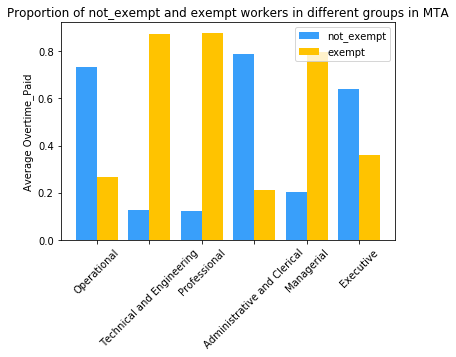

In [16]:
import pandas as pd
import numpy as np
exempt = pd.read_sql_query("SELECT group_type.group_type,  COUNT(DISTINCT EMPLOYEE.*) AS exempt_workers \
FROM salary \
JOIN authority \
ON salary.authority_key = authority.key \
JOIN employee \
ON salary.employee_key = employee.key \
JOIN dim_junk \
ON salary.dim_junk_key = dim_junk.key \
JOIN group_type \
ON salary.group_key = group_type.key \
WHERE authority.authority =  'Metropolitan Transportation Authority' and dim_junk.is_exempt = 'Y' \
GROUP BY group_type.group_type \
ORDER BY group_type.group_type \
LIMIT 10",con=engine)

not_exempt = pd.read_sql_query("SELECT group_type.group_type,  COUNT(DISTINCT EMPLOYEE.*) AS not_exempt_workers \
FROM salary \
JOIN authority \
ON salary.authority_key = authority.key \
JOIN employee \
ON salary.employee_key = employee.key \
JOIN dim_junk \
ON salary.dim_junk_key = dim_junk.key \
JOIN group_type \
ON salary.group_key = group_type.key \
WHERE authority.authority =  'Metropolitan Transportation Authority' and dim_junk.is_exempt = 'N' \
GROUP BY group_type.group_type \
ORDER BY group_type.group_type \
LIMIT 10",con=engine)

groups = ('Operational','Technical and Engineering','Professional','Administrative and Clerical','Managerial','Executive')


exempt_ratio = exempt['exempt_workers']/(exempt['exempt_workers']+not_exempt['not_exempt_workers'])
not_exempt_ratio = not_exempt['not_exempt_workers']/(exempt['exempt_workers']+not_exempt['not_exempt_workers'])
                           
N = 6
x = np.arange(N) 
width = 0.4


plt.bar(x, not_exempt_ratio, width,label="not_exempt",color="#399FFA")
plt.bar(x+ width, exempt_ratio, width,label="exempt",color='#FFC300')


plt.ylabel('Average Overtime_Paid')
plt.title("Proportion of not_exempt and exempt workers in different groups in MTA")

plt.xticks(x + width / 2, groups,rotation = 45)
plt.legend(loc='best')
plt.show()


#### 4.1.4 Step Four: Study the differences between Full-time pay and Part-time pay

- There is an obvious upward trend for the overtime pay for full time jobs, but decreasing trend for part time jobs. 
  - On the one hand, it my be due to the fact that part time workers are not compensated fairly, they get less paid than actually they should be paid. The FLSA doesn’t differentiate the overtime payment for part-time workers from that for full-time workers. Any workers who work over 40 hours a week should get overtime pay.
  - On the other hand, it may reflect that full time workers work much longer time than part-time workers.
- No matter which is the case, it is advisable that MTA reduces overtime working hours and increase overtime compensation per hour. Discrimination to part-time workers should be avoided, and labor contract should be improved to protect the basic rights for part-time workers.


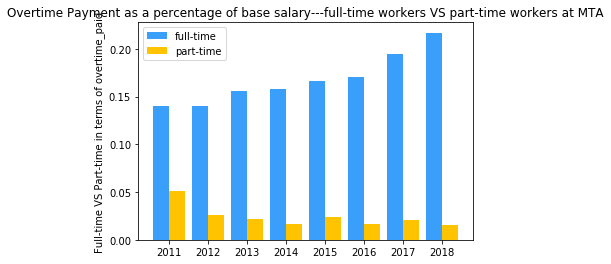

In [20]:
import pandas as pd
import numpy as np
data1 = pd.read_sql_query("\
                       SELECT date.year, ROUND(SUM(salary.overtime_paid),2)/ROUND(SUM(salary.base_annualized_salary),2) as over\
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority'and pay_type.pay_type = 'FT'\
                       GROUP BY date.year",con=engine)
data2 = pd.read_sql_query("\
                       SELECT date.year, ROUND(SUM(salary.overtime_paid),2)/ROUND(SUM(salary.base_annualized_salary),2) as over\
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority' and pay_type.pay_type = 'PT'\
                       GROUP BY date.year",con=engine)

N = 8

fulltime = data1['over']
parttime = data2['over']


x = np.arange(N) 
width = 0.4

plt.bar(x, fulltime, width,label="full-time",color="#399FFA")
plt.bar(x+ width, parttime, width,label="part-time",color='#FFC300')


plt.ylabel('Full-time VS Part-time in terms of overtime_paid')
plt.title("Overtime Payment as a percentage of base salary---full-time workers VS part-time workers at MTA")

plt.xticks(x + width / 2, ('2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'))
plt.legend(loc='best')
plt.show()

### 4.2 Business Question: What can the trend of salary for employees from different positions tell us? 

Salary is an important measurement to evaluate employee's performance and department's operating status. Thus, we can find out some important information by analyzing the salary trend of employee in different positions.

#### 4.2.1 Step One: Which group of employee should we focus on?

From previous question, we already knew that employees from Metropolitan Transportation Authority take up the largest proportion of data. Thus we will also use MTA as our target authority. At first, we should see whether the data of all groups of employees are available to show the line chart.

In [128]:
%%sql
SELECT group_type.group_type,  COUNT(DISTINCT date.year) AS available_data_year
FROM salary
JOIN authority 
ON salary.authority_key = authority.key
JOIN date
ON salary.date_key = date.key
JOIN pay_type
ON salary.pay_type_key = pay_type.key
JOIN group_type 
ON salary.group_key = group_type.key
WHERE authority.authority =  'Metropolitan Transportation Authority' and pay_type.pay_type = 'PT'  
GROUP BY group_type.group_type


 * postgresql://student@/week12
6 rows affected.


group_type,available_data_year
Administrative and Clerical,8
Executive,3
Managerial,8
Operational,8
Professional,8
Technical and Engineering,2


In [127]:
%%sql
SELECT group_type.group_type,  COUNT(DISTINCT date.year) AS available_data_year
FROM salary
JOIN authority 
ON salary.authority_key = authority.key
JOIN date
ON salary.date_key = date.key
JOIN pay_type
ON salary.pay_type_key = pay_type.key
JOIN group_type 
ON salary.group_key = group_type.key
WHERE authority.authority =  'Metropolitan Transportation Authority' and pay_type.pay_type = 'FT'  
GROUP BY group_type.group_type


 * postgresql://student@/week12
6 rows affected.


group_type,available_data_year
Administrative and Clerical,8
Executive,8
Managerial,8
Operational,8
Professional,8
Technical and Engineering,8


For full-time job, the dataset contains all years from 2011-2018. However, it is shown that the data for part-time executive, technical and engineering employees are incomplete. Data for most of the years are missing. So we will use the other four groups of employees in the following analysis.

#### 4.2.2 Step Two: Which salary index should we use?

There are four types of salary in the data. As we mentioned before, total compensation is the total amount of money that an employee earns, which equals to actual salaty paid + extra pay + overtime paid + performance bonus + other compensation. However, we should know that not only base annualized salary that set by the authority can affect actual salary, but also employee's actual work time can. Thus, if an employee is hired at the end of year, he/she will earn relatively little amount of actual salary. So it will lead to huge bias. As a result, this variable can not show the salary level properly.


Also, if we sum all those extra salaries as total extra pay, we can find the result that:

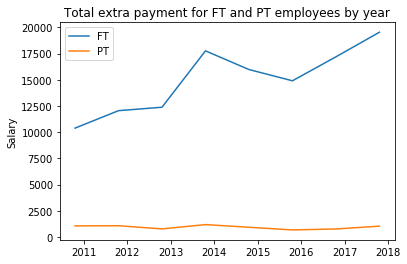

In [121]:
import pandas as pd
import numpy as np

pa = pd.read_sql_query("\
                       SELECT date.year, ROUND(AVG(salary.extra_pay),2)+ROUND(AVG(salary.overtime_paid),2)+ROUND(AVG(salary.performance_bonus),2)+ROUND(AVG(salary.other_compensation),2) as other \
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority' and pay_type.pay_type = 'FT'\
                       GROUP BY date.year",con=engine)
pb = pd.read_sql_query("\
                       SELECT date.year, ROUND(AVG(salary.extra_pay),2)+ROUND(AVG(salary.overtime_paid),2)+ROUND(AVG(salary.performance_bonus),2)+ROUND(AVG(salary.other_compensation),2) as other \
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority' and pay_type.pay_type = 'PT'\
                       GROUP BY date.year",con=engine)
N = 8
other_salary = pa["other"]
other_salary_2 = pb["other"]

x = np.arange(N) 
width = 0.4
plt.plot(other_salary, label="FT") 
plt.plot(other_salary_2, label="PT")

plt.ylabel('Salary')
plt.title('Total extra payment for FT and PT employees by year')

plt.xticks(x + width / 2, ('2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'))
plt.legend(loc='best')
plt.show()

The result shows that full time employee has an overall increasing trend of extra salary. During 2014 to 2016, the extra salary had a slightly decrease. There may be two possible reasons. First, there may be some economic issues during 2014 to 2016. The authority had to cut its employees extra salary to save money. Second, during that years, performance of employees may not be that outstanding, or they may not be willing to work overtime as they did before. No matter what the true reason is, it led to the decrease of their extra salary.

However, the extra salary for part time employees is relatively stable. It's slightly fluctuating around 0. It is reasonable to assume that part time employees will care less about overtime work or outstanding performance, which makes them make little effort to earn extra money. Thus, it is meaningless if we compare full time employee's extra salary with part time employee's extra salary. We will now focus only on their base annualized salary.

#### 4.2.3 Step Three: Trend of Part-time Base Annualized Salary

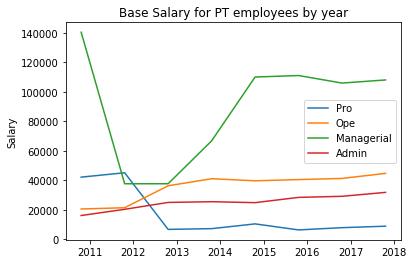

In [122]:
import pandas as pd
import numpy as np
pa1 = pd.read_sql_query("\
                       SELECT date.year, ROUND(AVG(salary.base_annualized_salary),2) as base \
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority' and group_type.group_type = 'Professional'and pay_type.pay_type = 'PT'\
                       GROUP BY date.year",con=engine)

pa2 = pd.read_sql_query("\
                       SELECT date.year, ROUND(AVG(salary.base_annualized_salary),2) as base \
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority'and group_type.group_type = 'Operational'and pay_type.pay_type = 'PT'\
                       GROUP BY date.year",con=engine)



pa3 = pd.read_sql_query("\
                       SELECT date.year, ROUND(AVG(salary.base_annualized_salary),2) as base \
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority' and group_type.group_type = 'Managerial'and pay_type.pay_type = 'PT'\
                       GROUP BY date.year",con=engine)
pa4 = pd.read_sql_query("\
                       SELECT date.year, ROUND(AVG(salary.base_annualized_salary),2) as base \
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority' and group_type.group_type = 'Administrative and Clerical'and pay_type.pay_type = 'PT'\
                       GROUP BY date.year",con=engine)
N = 8
base_salary = pa1["base"]
base_2_salary = pa2['base']
base_3_salary = pa3['base']
base_4_salary = pa4['base']

x = np.arange(N) 
width = 0.4
plt.plot(base_salary, label="Pro")
plt.plot(base_2_salary, label="Ope")   
plt.plot(base_3_salary, label="Managerial")  
plt.plot(base_4_salary, label="Admin") 

plt.ylabel('Salary')
plt.title('Base Salary for PT employees by year')

plt.xticks(x + width / 2, ('2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'))
plt.legend(loc='best')
plt.show()

Look at the salary of part time job employees. We can see some interesting trends. While employees of operational and administrative and clerical have an increasing salary, the salary for managers and professional employees are decreasing decrease during 2012-2013. The decreasing for managerial employees is extremely significant. From 140000 to 4000, a 70% percent cut of salary, indicates at that time, part-time managerial employees were having a bad time. After then it returns to the normal trend. But for professional employees, their base annulized salary is keeping at that low level since then.

#### 4.2.3 Step Three: Trend of Full-time Base Annualized Salary

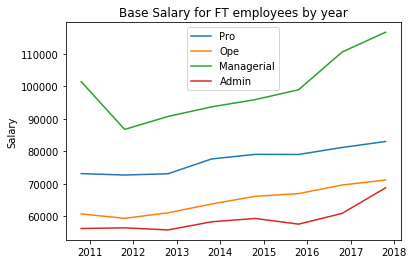

In [123]:
import pandas as pd
import numpy as np
pa1 = pd.read_sql_query("\
                       SELECT date.year, ROUND(AVG(salary.base_annualized_salary),2) as base \
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority' and group_type.group_type = 'Professional'and pay_type.pay_type = 'FT'\
                       GROUP BY date.year",con=engine)

pa2 = pd.read_sql_query("\
                       SELECT date.year, ROUND(AVG(salary.base_annualized_salary),2) as base \
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority'and group_type.group_type = 'Operational'and pay_type.pay_type = 'FT'\
                       GROUP BY date.year",con=engine)


pa3 = pd.read_sql_query("\
                       SELECT date.year, ROUND(AVG(salary.base_annualized_salary),2) as base \
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority' and group_type.group_type = 'Managerial'and pay_type.pay_type = 'FT'\
                       GROUP BY date.year",con=engine)
pa4 = pd.read_sql_query("\
                       SELECT date.year, ROUND(AVG(salary.base_annualized_salary),2) as base \
                       FROM salary\
                       JOIN authority\
                       ON salary.authority_key = authority.key\
                       JOIN group_type\
                       ON salary.group_key = group_type.key\
                       JOIN date\
                       ON salary.date_key = date.key\
                       JOIN pay_type\
                       ON salary.pay_type_key = pay_type.key\
                       WHERE authority.authority = 'Metropolitan Transportation Authority' and group_type.group_type = 'Administrative and Clerical'and pay_type.pay_type = 'FT'\
                       GROUP BY date.year",con=engine)
N = 8
base_salary = pa1["base"]
base_2_salary = pa2['base']
base_3_salary = pa3['base']
base_4_salary = pa4['base']

x = np.arange(N) 
width = 0.4
plt.plot(base_salary, label="Pro")
plt.plot(base_2_salary, label="Ope")   
plt.plot(base_3_salary, label="Managerial")  
plt.plot(base_4_salary, label="Admin") 

plt.ylabel('Salary')
plt.title('Base Salary for FT employees by year')

plt.xticks(x + width / 2, ('2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'))
plt.legend(loc='best')
plt.show()

Now we look at the trend for full time employees. The overall trends for all different groups of employees are steadily increasing, which is the normal pattern for an authority. However, we could still see a slightly decrease for managerial employees during 2012.

With previous two line plots, we can conclude that during 2012-2013, different employees of MTA have different salary status. For operating employees and Administrative and Clerical employees, their base annualized salary are keeping steadily increasing. However, for professional employees, the base salary for part time employees is decreasing. What's more, base salary for both part time and full time managerial employees had a significant decrease. This trend indicates that managerial and professional position in MTA in 2012-2013 were suffering a serious salary cut. This may due to some operating problems that force the authority to save money. However, since then, salary for managerial employees was recovered. For professional part time employees, their base salary remained that low level, even far lower than all other positions. But for full time professional employees, they have a relatively high base annualized salary, which is only lower than managers.

This interesting result indicates that since 2012, the demand of professional employees is decreasing. Thus, MTA cut the salary of part time professional employees. But overall, the authority hasn't met serious operating problems, because it doesn't cut the salary for full time employees.

### 4.3 Business Question: What is the salary distribution for each job group？

**Question Aim:**

This question focuses on the distribution of salary for each job group. Due to the limitation of total salary, company executives want to know the flow of salary and max their benefit, which divide the money to the group who can create the maximum beneifit.

#### 4.3.1 What is proportion for salary types in each job group?

- For this sub task, a table about group type and salary consitents will be built. After the table was built, six of pie charts of salary consistents in each group will be shown up.
- From the six pie charts, it is easy to see that all of them are highly dependent on actual salary, which means all the six groups are stable that employees will get their regular salary on the end of month and there is no signal of salary fluctuation occured.
- Operational group and technical & Engineering group have certain number of overtime salary which over ten percents of total salary in their own groups. Based on this observation, the company executives should pay more attention on the working time of these two groups' employees. Even they get some of overtime salary, they still need a few time to spend on their own live. Moreover, according to the state law in New York State, overtime salary is mandatory for the works who work out of their regular job hours. So, it is a good suggestion that the employees who work overtime can a certain percent of bonus for their overtime work, which can encourage them to work beside the mandatory salary.

In [6]:
%%sql
SELECT group_type.group_type, ROUND(avg(actual_salary_paid),2) AS avg_actual, ROUND(avg(overtime_paid),2) AS avg_overtime, ROUND(avg(performance_bonus),2) AS avg_bonus,
       ROUND(avg(extra_pay),2) AS avg_extra, ROUND(avg(other_compensation),2) AS avg_other
FROM salary 
JOIN group_type
ON salary.group_key = group_type.key
GROUP BY group_type
ORDER BY group_type

 * postgresql://student@/week12
6 rows affected.


group_type,avg_actual,avg_overtime,avg_bonus,avg_extra,avg_other
Administrative and Clerical,39248.80,3230.84,28.83,1003.67,425.74
Executive,167091.54,62.41,5035.34,6088.23,3141.92
Managerial,90381.44,6143.14,128.88,5283.44,419.69
Operational,54386.17,11992.36,49.12,1803.86,749.72
Professional,67606.75,4030.73,85.68,2137.52,894.78
Technical and Engineering,65580.10,9543.94,22.65,1441.10,343.75


In [10]:

avg_salary = pd.read_sql_query('SELECT group_type.group_type, ROUND(avg(actual_salary_paid),2) AS avg_actual, ROUND(avg(overtime_paid),2) AS avg_overtime, ROUND(avg(performance_bonus),2) AS avg_bonus,\
                                      ROUND(avg(extra_pay),2) AS avg_extra, ROUND(avg(other_compensation),2) AS avg_other\
                               FROM salary\
                               JOIN group_type\
                               ON salary.group_key = group_type.key\
                               GROUP BY group_type\
                               ORDER BY group_type',con=engine)

In [17]:
avg_clean=avg_salary.transpose()
avg_clean.columns=avg_clean.iloc[0]
avg_clean = avg_clean.drop(['group_type'])
avg_clean.reset_index(level=0,inplace=True)
avg_clean

group_type,index,Administrative and Clerical,Executive,Managerial,Operational,Professional,Technical and Engineering
0,avg_actual,39248.8,167092,90381.4,54386.2,67606.8,65580.1
1,avg_overtime,3230.84,62.41,6143.14,11992.4,4030.73,9543.94
2,avg_bonus,28.83,5035.34,128.88,49.12,85.68,22.65
3,avg_extra,1003.67,6088.23,5283.44,1803.86,2137.52,1441.1
4,avg_other,425.74,3141.92,419.69,749.72,894.78,343.75


In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

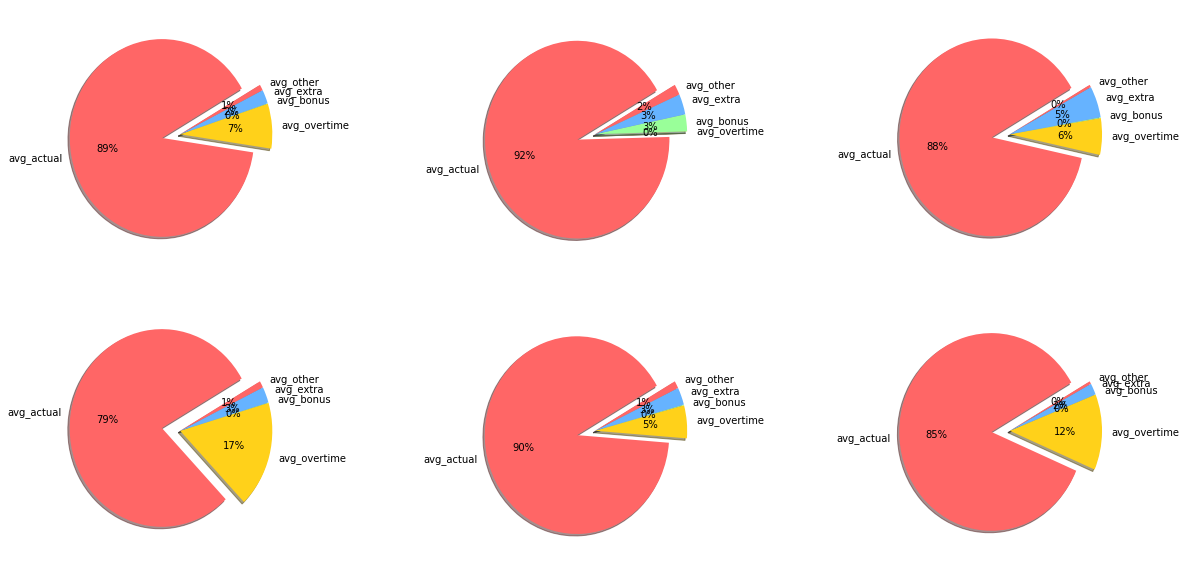

In [63]:
fig, axs = plt.subplots(2, 3,figsize=(19, 10))
axs[0,0].pie(avg_clean['Administrative and Clerical'],
       labels= avg_clean['index'],
       shadow = True,
       startangle = 30,autopct='%.0f%%',colors = ['#ff6666','#ffd11a','#99ff99','#66b3ff'],
       explode = (0.2,0,0,0,0))

axs[0,1].pie(avg_clean['Executive'],
       labels= avg_clean['index'],
       shadow = True,autopct='%.0f%%',colors = ['#ff6666','#ffd11a','#99ff99','#66b3ff'],
       startangle = 30,explode = (0.2,0,0,0,0))

axs[0,2].pie(avg_clean['Managerial'],
       labels= avg_clean['index'],
       shadow = True,autopct='%.000f%%',colors = ['#ff6666','#ffd11a','#99ff99','#66b3ff'],
       startangle = 30,explode = (0.2,0,0,0,0))

axs[1,0].pie(avg_clean['Operational'],
       labels= avg_clean['index'],autopct='%.0f%%',
       shadow = True,colors = ['#ff6666','#ffd11a','#99ff99','#66b3ff'],
       startangle = 30,explode = (0.2,0,0,0,0))

axs[1,1].pie(avg_clean['Professional'],
       labels= avg_clean['index'],autopct='%.0f%%',
       shadow = True,colors = ['#ff6666','#ffd11a','#99ff99','#66b3ff'],
       startangle = 30,explode = (0.2,0,0,0,0))

axs[1,2].pie(avg_clean['Technical and Engineering'],
       labels= avg_clean['index'],autopct='%.0f%%',
       shadow = True,colors = ['#ff6666','#ffd11a','#99ff99','#66b3ff'],
       startangle = 30,explode = (0.2,0,0,0,0))
fig.subplots_adjust(wspace=.8)
plt.show()